# MobileNetV3 vs EfficientNetB0 Training on RPW Dataset

This notebook compares the performance of MobileNetV3 and EfficientNetB0 models on a custom image classification dataset. The implementation is RAM-optimized by loading all images into memory at the start, which can significantly speed up training when working with smaller datasets.

## Overview
- We'll use transfer learning with pre-trained models
- The models will be partially frozen to preserve low-level features
- Custom classifiers will be added to adapt to our binary classification task
- Performance metrics will be evaluated and visualized

## Setting Up the Environment

First, let's import all necessary libraries and set up our device configuration.

In [ ]:
import os
import glob
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from torchvision.models import (
    mobilenet_v3_large,
    MobileNet_V3_Large_Weights,
    efficientnet_b0,
    EfficientNet_B0_Weights,
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Device config - will use CUDA if available, Apple Metal if available, otherwise CPU
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print("Using device:", device)
use_amp = device.type == "cuda"  # Only use AMP with CUDA
scaler = GradScaler("cuda", enabled=use_amp)

Using device: mps


In [11]:
seed = 42
# Set seed for reproducibility
torch.manual_seed(seed)

## Custom Dataset Implementation

Our `InMemoryDataset` class loads all images into RAM at initialization. This approach trades memory for speed, which is beneficial for smaller datasets as it eliminates disk I/O during training.

In [12]:
class InMemoryDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.data = []
        self.labels = []

        class_dirs = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_dirs)}

        for cls_name in class_dirs:
            cls_path = os.path.join(root_dir, cls_name)
            img_paths = glob.glob(os.path.join(cls_path, "*.*"))
            for path in img_paths:
                try:
                    img = Image.open(path).convert("RGB")
                    if self.transform:
                        img = self.transform(img)
                    self.data.append(img)
                    self.labels.append(self.class_to_idx[cls_name])
                except Exception as e:
                    print(f"Skipping image {path}: {e}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

## Model Building Functions

We'll define functions for:
1. Partial freezing of model layers to leverage pre-trained weights
2. Building the model architecture with custom classifier heads

In [13]:
# Partial freezing function - freezes a proportion of the early layers
def freeze_partial(model, freeze_ratio=0.7):
    layers = list(model.features.children())
    num_freeze = int(len(layers) * freeze_ratio)
    for i, layer in enumerate(layers):
        if i < num_freeze:
            for param in layer.parameters():
                param.requires_grad = False


# Model builder - constructs either MobileNetV3 or EfficientNetB0 with custom classifier
def build_model(model_name, num_classes=2, freeze_ratio=0.7):
    if model_name == "mobilenet":
        weights = MobileNet_V3_Large_Weights.DEFAULT
        model = mobilenet_v3_large(weights=weights)
        model.classifier = nn.Sequential(
            nn.Linear(model.classifier[0].in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
        )
    elif model_name == "efficientnet":
        weights = EfficientNet_B0_Weights.DEFAULT
        model = efficientnet_b0(weights=weights)
        model.classifier = nn.Sequential(
            nn.Linear(model.classifier[1].in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
        )
    else:
        raise ValueError("Unsupported model name")

    freeze_partial(model, freeze_ratio)
    return model.to(device)

## Training and Evaluation Functions

Next, we'll define functions for:
1. Training the models with early stopping
2. Evaluating model performance with multiple metrics
3. Visualizing the training process and results

In [ ]:
# Training and validation loop
def train_model(model, train_loader, val_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005
    )

    # Initialize GradScaler for mixed precision if using CUDA
    scaler = torch.amp.GradScaler(enabled=device.type == "cuda")

    train_loss_hist, val_loss_hist = [], []
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for imgs, labels in train_loader:
            # Safe transfer to device (with non_blocking=True only for CUDA)
            if device.type == "cuda":
                imgs = imgs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
            else:
                imgs = imgs.to(device)
                labels = labels.to(device)

            optimizer.zero_grad()

            # Mixed precision training
            with autocast(
                enabled=device.type == "cuda"
            ):  # Enable autocast if CUDA is used
                outputs = model(imgs)
                loss = criterion(outputs, labels)

            # Scale the loss and backpropagate
            if device.type == "cuda":
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            total_train_loss += loss.item()

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                # Safe transfer to device (with non_blocking=True only for CUDA)
                if device.type == "cuda":
                    imgs = imgs.to(device, non_blocking=True)
                    labels = labels.to(device, non_blocking=True)
                else:
                    imgs = imgs.to(device)
                    labels = labels.to(device)

                with autocast(
                    enabled=device.type == "cuda"
                ):  # Enable autocast for validation as well
                    outputs = model(imgs)
                    loss = criterion(outputs, labels)

                total_val_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        train_loss_hist.append(avg_train_loss)
        val_loss_hist.append(avg_val_loss)

        print(
            f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}"
        )

    return train_loss_hist, val_loss_hist


# Evaluation function with various metrics and confusion matrix visualization
def evaluate(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            # Safe transfer to device (with non_blocking=True only for CUDA)
            if device.type == "cuda":
                imgs = imgs.to(device, non_blocking=True)
            else:
                imgs = imgs.to(device)

            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print(
        f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}"
    )
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return acc, prec, rec, f1


# Plot training curves
def plot_loss(train_loss, val_loss, title):
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Val Loss")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

## Data Preparation

Let's set up our data transformations and load the datasets into memory.

In [15]:
# Image preprocessing transforms (same as training)
img_size = 224
common_transforms = transforms.Compose(
    [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Your actual dataset path (contains RPW/ and NRPW/)
data_path = "./data"

# Load dataset from RPW/ and NRPW/
full_dataset = datasets.ImageFolder(root=data_path, transform=common_transforms)

# Split into train, val, test
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Ensure reproducibility
generator = torch.Generator().manual_seed(seed)
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size], generator=generator
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print info
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Classes: {full_dataset.classes}")  # ['NRPW', 'RPW']

Train dataset size: 9800
Validation dataset size: 2100
Test dataset size: 2100
Classes: ['NRPW', 'RPW']


## Train and Evaluate MobileNetV3

Now let's train our first model, MobileNetV3, and evaluate its performance.


===== Training MobileNetV3 =====


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /Users/ketchup/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:02<00:00, 10.2MB/s]


Epoch 1/10 - Train Loss: 0.0508 - Val Loss: 0.0008
Epoch 2/10 - Train Loss: 0.0116 - Val Loss: 0.0080
Epoch 3/10 - Train Loss: 0.0089 - Val Loss: 0.0084
Epoch 4/10 - Train Loss: 0.0078 - Val Loss: 0.0042
Epoch 5/10 - Train Loss: 0.0014 - Val Loss: 0.0034
Epoch 6/10 - Train Loss: 0.0085 - Val Loss: 0.0002
Epoch 7/10 - Train Loss: 0.0095 - Val Loss: 0.0084
Epoch 8/10 - Train Loss: 0.0083 - Val Loss: 0.0149
Epoch 9/10 - Train Loss: 0.0046 - Val Loss: 0.0086
Epoch 10/10 - Train Loss: 0.0064 - Val Loss: 0.0169

===== MobileNetV3 Evaluation =====
Accuracy: 0.9967, Precision: 1.0000, Recall: 0.9908, F1 Score: 0.9954


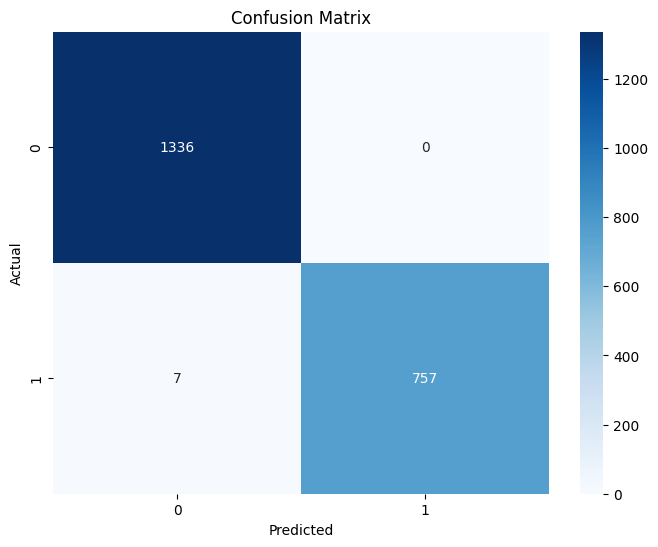

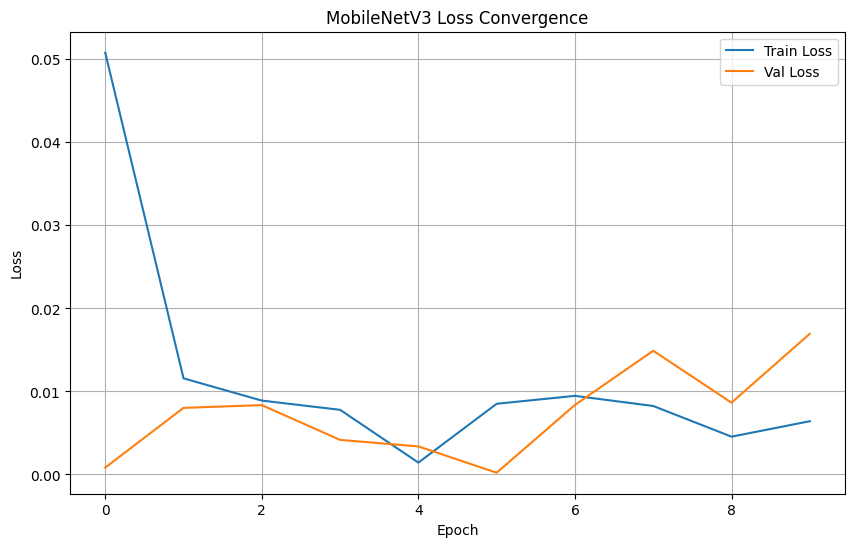

In [8]:
# Train and evaluate MobileNetV3
print("\n===== Training MobileNetV3 =====")
mobilenet_model = build_model('mobilenet')
mobile_train_loss, mobile_val_loss = train_model(mobilenet_model, train_loader, val_loader, epochs=10)

print("\n===== MobileNetV3 Evaluation =====")
mobile_metrics = evaluate(mobilenet_model, test_loader)
plot_loss(mobile_train_loss, mobile_val_loss, "MobileNetV3 Loss Convergence")

## Train and Evaluate EfficientNetB0

Next, let's train and evaluate the EfficientNetB0 model using the same approach.


===== Training EfficientNetB0 =====


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/ketchup/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:02<00:00, 7.91MB/s]


Epoch 1/10 - Train Loss: 0.0802 - Val Loss: 0.0025
Epoch 2/10 - Train Loss: 0.0213 - Val Loss: 0.0067
Epoch 3/10 - Train Loss: 0.0262 - Val Loss: 0.0019
Epoch 4/10 - Train Loss: 0.0170 - Val Loss: 0.0032
Epoch 5/10 - Train Loss: 0.0111 - Val Loss: 0.0004
Epoch 6/10 - Train Loss: 0.0093 - Val Loss: 0.0012
Epoch 7/10 - Train Loss: 0.0068 - Val Loss: 0.0020
Epoch 8/10 - Train Loss: 0.0162 - Val Loss: 0.0009
Epoch 9/10 - Train Loss: 0.0107 - Val Loss: 0.0017
Epoch 10/10 - Train Loss: 0.0049 - Val Loss: 0.0034

===== EfficientNetB0 Evaluation =====
Accuracy: 0.9990, Precision: 1.0000, Recall: 0.9974, F1 Score: 0.9987


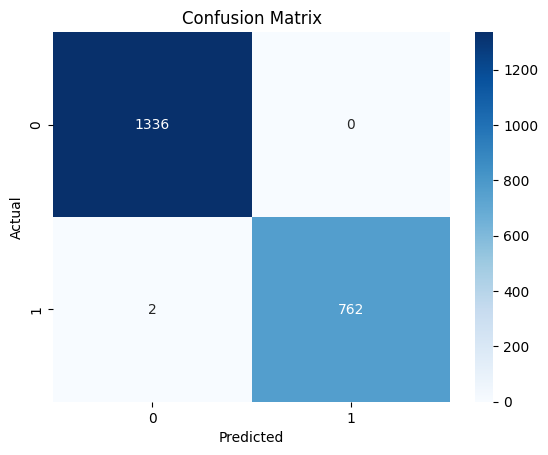

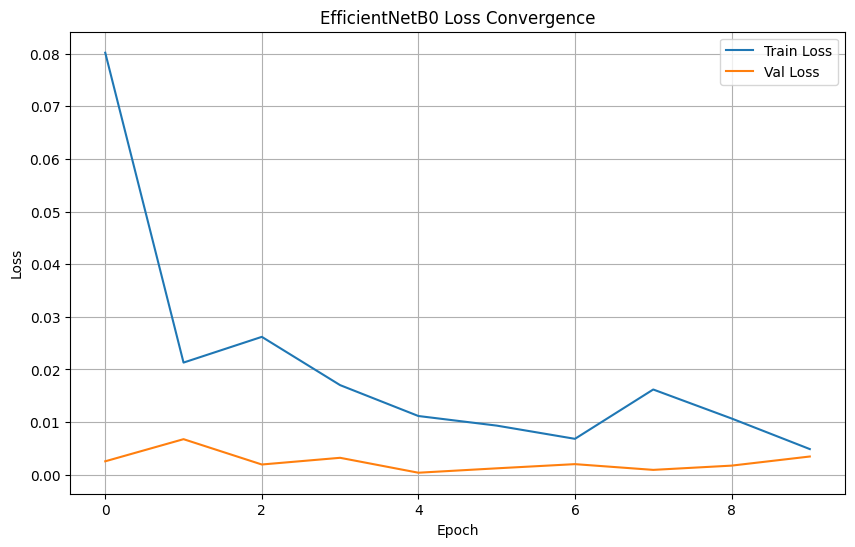

In [16]:
# Train and evaluate EfficientNetB0
print("\n===== Training EfficientNetB0 =====")
efficientnet_model = build_model('efficientnet')
eff_train_loss, eff_val_loss = train_model(efficientnet_model, train_loader, val_loader, epochs=10)

print("\n===== EfficientNetB0 Evaluation =====")
eff_metrics = evaluate(efficientnet_model, test_loader)
plot_loss(eff_train_loss, eff_val_loss, "EfficientNetB0 Loss Convergence")

## Model Comparison

Finally, let's compare the performance of both models side by side.

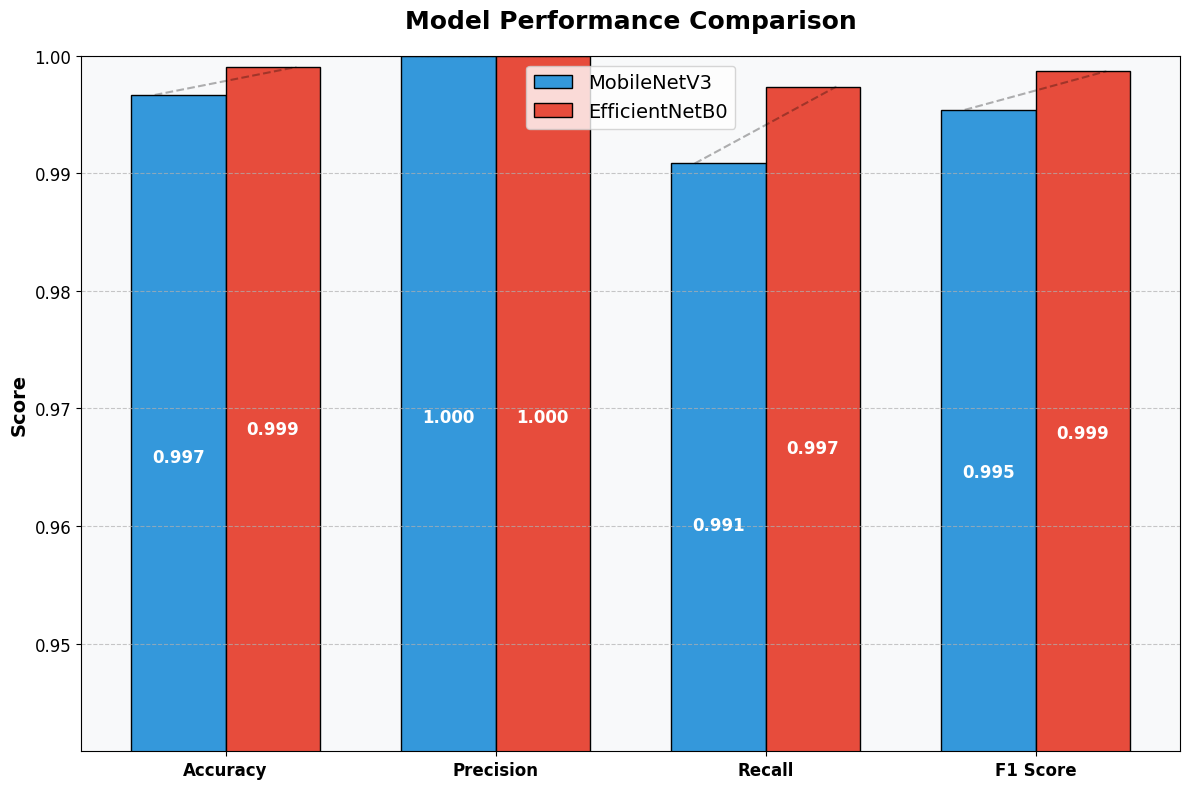

In [31]:
# Compare model performances
models = ["MobileNetV3", "EfficientNetB0"]
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]

mobile_values = list(mobile_metrics)
eff_values = list(eff_metrics)

# Plot comparison with improved styling
plt.figure(figsize=(12, 8))
x = range(len(metrics))
width = 0.35

# Use more distinctive colors with higher contrast
bar1 = plt.bar(
    [i - width / 2 for i in x],
    mobile_values,
    width,
    label="MobileNetV3",
    color="#3498db",
    edgecolor="black",
    linewidth=1,
)
bar2 = plt.bar(
    [i + width / 2 for i in x],
    eff_values,
    width,
    label="EfficientNetB0",
    color="#e74c3c",
    edgecolor="black",
    linewidth=1,
)

# Adjust y-axis scale to focus on differences
# Find min value and set scale to start a bit below that
min_val = min(min(mobile_values), min(eff_values))
y_min = max(0, min_val - 0.05)  # Don't go below 0, but give some padding
plt.ylim(y_min, 1.0)

# Improve overall styling
plt.ylabel("Score", fontsize=14, fontweight="bold")
plt.title("Model Performance Comparison", fontsize=18, fontweight="bold", pad=20)
plt.xticks(x, metrics, fontsize=12, fontweight="bold")
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add a light background color for better readability
plt.gca().set_facecolor("#f8f9fa")

# Add value labels with improved positioning and styling
for i, v in enumerate(mobile_values):
    plt.text(
        i - width / 2,
        v - 0.03,
        f"{v:.3f}",
        ha="center",
        va="top",
        fontweight="bold",
        fontsize=12,
        color="white",
    )

for i, v in enumerate(eff_values):
    plt.text(
        i + width / 2,
        v - 0.03,
        f"{v:.3f}",
        ha="center",
        va="top",
        fontweight="bold",
        fontsize=12,
        color="white",
    )

# Add horizontal lines to help compare values
for i in range(len(metrics)):
    x_left = i - width / 2 - width / 4
    x_right = i + width / 2 + width / 4
    y_mobile = mobile_values[i]
    y_eff = eff_values[i]

    # Add a light connecting line between the bars for easier comparison
    plt.plot([x_left, x_right], [y_mobile, y_eff], "k--", alpha=0.3)

plt.tight_layout()
plt.show()

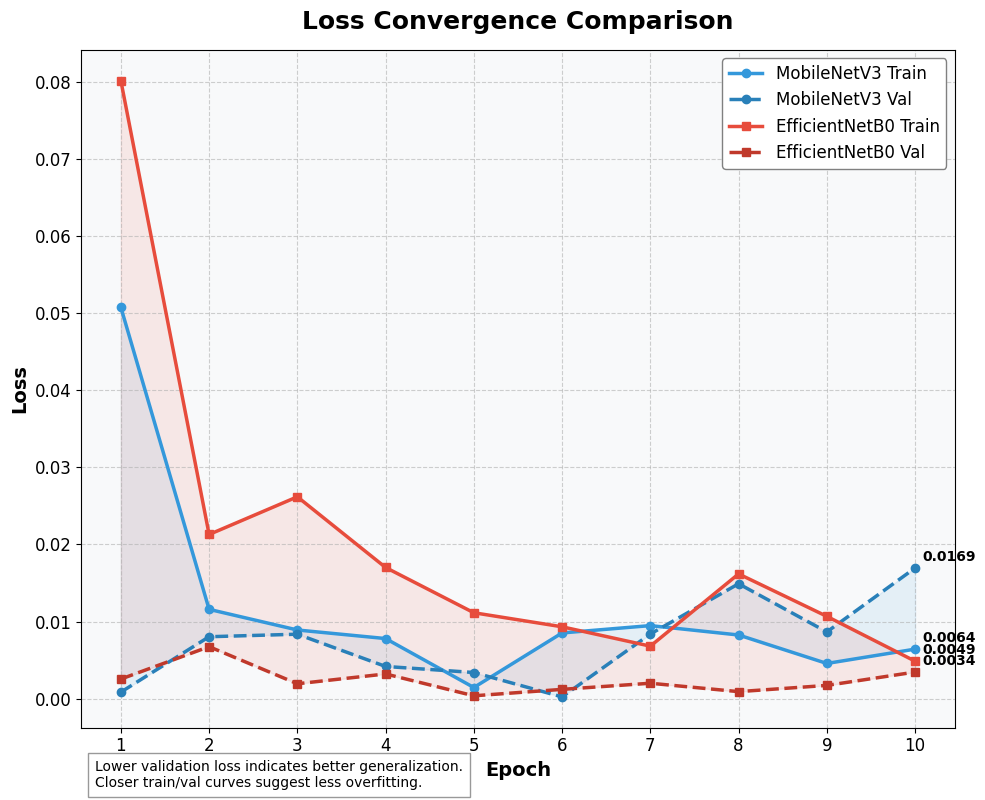

In [ ]:
# Create a more informative and visually appealing loss convergence plot
plt.figure(figsize=(12, 8))

# Use distinct color scheme with better line styling
plt.plot(mobile_train_loss, label="MobileNetV3 Train", color='#3498db', linewidth=2.5, marker='o', markersize=6)
plt.plot(mobile_val_loss, label="MobileNetV3 Val", color='#2980b9', linewidth=2.5, linestyle='--', marker='o', markersize=6)
plt.plot(eff_train_loss, label="EfficientNetB0 Train", color='#e74c3c', linewidth=2.5, marker='s', markersize=6)
plt.plot(eff_val_loss, label="EfficientNetB0 Val", color='#c0392b', linewidth=2.5, linestyle='--', marker='s', markersize=6)

# Add shaded regions for better train/val comparison
epochs = range(len(mobile_train_loss))
plt.fill_between(epochs, mobile_train_loss, mobile_val_loss, color='#3498db', alpha=0.1)
plt.fill_between(epochs, eff_train_loss, eff_val_loss, color='#e74c3c', alpha=0.1)

# Improve styling
plt.title("Loss Convergence Comparison", fontsize=18, fontweight='bold', pad=15)
plt.xlabel("Epoch", fontsize=14, fontweight='bold')
plt.ylabel("Loss", fontsize=14, fontweight='bold')

# Set x-ticks to be integers (epoch numbers)
plt.xticks(epochs, [i+1 for i in epochs], fontsize=12)
plt.yticks(fontsize=12)

# Add grid but make it less dominant
plt.grid(True, linestyle='--', alpha=0.6)

# Enhance legend
plt.legend(fontsize=12, frameon=True, facecolor='white', framealpha=1, edgecolor='gray', loc='upper right')

# Add a background color
plt.gca().set_facecolor('#f8f9fa')

# Add annotations for final loss values
last_epoch = len(mobile_train_loss) - 1
plt.annotate(f"{mobile_train_loss[-1]:.4f}", 
             (last_epoch, mobile_train_loss[-1]), 
             textcoords="offset points", 
             xytext=(5,5), 
             ha='left', 
             fontweight='bold',
             fontsize=10)

plt.annotate(f"{mobile_val_loss[-1]:.4f}", 
             (last_epoch, mobile_val_loss[-1]), 
             textcoords="offset points", 
             xytext=(5,5), 
             ha='left', 
             fontweight='bold',
             fontsize=10)

plt.annotate(f"{eff_train_loss[-1]:.4f}", 
             (last_epoch, eff_train_loss[-1]), 
             textcoords="offset points", 
             xytext=(5,5), 
             ha='left', 
             fontweight='bold',
             fontsize=10)

plt.annotate(f"{eff_val_loss[-1]:.4f}", 
             (last_epoch, eff_val_loss[-1]), 
             textcoords="offset points", 
             xytext=(5,5), 
             ha='left', 
             fontweight='bold',
             fontsize=10)

# Add a text box explaining what the plot shows
plt.figtext(0.10, 0.01, 
           "Lower validation loss indicates better generalization.\nCloser train/val curves suggest less overfitting.", 
           ha="left", 
           fontsize=10, 
           bbox={"facecolor":"white", "alpha":0.8, "pad":5, "edgecolor":"gray"})

plt.tight_layout()
plt.show()

## Save Models

Let's save our trained models for future use.

In [18]:
# Create directory for saving models
os.makedirs('saved_models', exist_ok=True)

# Save models
torch.save(mobilenet_model.state_dict(), 'saved_models/mobilenetv3_rpw.pth')
torch.save(efficientnet_model.state_dict(), 'saved_models/efficientnetb0_rpw.pth')

print("Models saved successfully!")

Models saved successfully!


## Conclusion

In this notebook, we've compared MobileNetV3 and EfficientNetB0 on a custom dataset. Key takeaways:

1. Both models are optimized for mobile/edge devices but have different trade-offs
2. MobileNetV3 typically has faster inference but may sacrifice some accuracy
3. EfficientNetB0 often achieves higher accuracy but with increased computational cost
4. The in-memory dataset approach works well for smaller datasets but may not be suitable for larger ones
5. Partial freezing of layers helps leverage pre-trained weights while adapting to our specific task

For real-world deployment, consider:
- Model quantization for further optimization
- More sophisticated data augmentation techniques
- Hyperparameter tuning (learning rate, batch size, etc.)
- Ensemble methods for potentially higher accuracy